MSE GradientBoosting

# Gradient Boosting — кратко и по сути

## 1. Идея
Сильная модель строится как сумма слабых моделей (деревьев):

$$
F_M(x) = \sum_{m=0}^{M} \eta \cdot h_m(x)
$$

---

## 2. Общий алгоритм

### Инициализация

Начальная модель — константа:

$$
F_0(x) = \arg\min_c \sum_{i=1}^{n} L(y_i, c)
$$

---

### Итерации (m = 1..M)

1. Вычисляем антиградиент функции потерь:

$$
r_i^{(m)} = - \frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}
$$

2. Обучаем дерево $h_m(x)$ предсказывать $r_i^{(m)}$

3. Обновляем модель:

$$
F_m(x) = F_{m-1}(x) + \eta \cdot h_m(x)
$$

---

## 3. Частный случай: регрессия (MSE)

Если функция потерь:

$$
L = \frac{1}{2}(y - F(x))^2
$$

Градиент:

$$
\frac{\partial L}{\partial F} = F(x) - y
$$

Антиградиент:

$$
y - F(x)
$$

→ Каждое новое дерево предсказывает остатки.

---

## 4. Ключевая идея

Gradient Boosting = градиентный спуск  
в пространстве функций.

На каждом шаге модель двигается в направлении
отрицательного градиента функции потерь.

---

## 5. Итоговая модель

$$
F_M(x) = F_0(x) + \sum_{m=1}^{M} \eta \cdot h_m(x)
$$



In [54]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression

X, y = make_regression(n_samples=200, n_features=5, noise=10, random_state=42)

class MSEGradientBoostingRegressor:
  def __init__(self, n_estimators, learning_rate, max_depth, score_func):
    self.n_estimators = n_estimators
    self.learning_rate = learning_rate
    self.max_depth = max_depth
    self.trees = []
    self.F0 = None
    self.score_func = score_func

  def fit(self, X, y):
    self.F0 = np.mean(y)
    F = np.full_like(y, self.F0, dtype=float)

    for _ in range(self.n_estimators):
      tree = DecisionTreeRegressor(max_depth=self.max_depth)
      residuals = y - F

      tree.fit(X, residuals)
      update = tree.predict(X)
      score = self.score_split(update, residuals)

      F += self.learning_rate * update

      self.trees.append(tree)


  def predict(self, X):
    F = np.full(X.shape[0], self.F0, dtype=float)
    for tree in self.trees:
      F += self.learning_rate * tree.predict(X)
    return F

  def score_split(self, p, h):
    if self.score_func == 'L2':
      return np.sum((p - h) ** 2)
    elif self.score_func == 'Cosine':
      p_norm = np.linalg.norm(p)
      h_norm = np.linalg.norm(h)

      if p_norm == 0 or h_norm == 0:
        return 1.0

      return 1 - np.dot(p, h) / (p_norm * h_norm)



In [73]:
import numpy as np

class TreeNode:
  def __init__(self, depth=0, max_depth=3):
    self.depth = depth
    self.max_depth = max_depth
    self.feature = None
    self.threshold = None
    self.value = None
    self.left = None
    self.right = None

  @staticmethod
  def cosine_distance(p_val, h_vec):
    p_vec = np.full_like(h_vec, p_val)
    p_norm = np.linalg.norm(p_vec)
    h_norm = np.linalg.norm(h_vec)
    if p_norm == 0 or h_norm == 0:
      return 1.0

    return 1 - np.dot(p_vec, h_vec) / (p_norm * h_norm)

  def fit(self, X, h, score_func='L2'):
    N, D = X.shape

    if self.depth >= self.max_depth or N <= 2:
      self.value = np.mean(h)
      return

    best_score = float('inf')
    best_feature = None
    best_threshold = None
    best_left_idx = None
    best_right_idx = None

    for j in range(D):
      thresholds = np.unique(X[:, j])
      for t in thresholds:
        left_idx = X[:, j] <= t
        right_idx = X[:, j] > t

        if np.sum(left_idx) == 0 or np.sum(right_idx) == 0:
          continue

        h_left, h_right = h[left_idx], h[right_idx]

        p_left = np.mean(h_left)
        p_right = np.mean(h_right)

        if score_func == 'L2':
          score = np.sum((h_left - p_left)**2) + np.sum((h_right - p_right)**2)
        elif score_func == 'Cosine':
          score = TreeNode.cosine_distance(p_left, h_left) + TreeNode.cosine_distance(p_right, h_right)

        if score < best_score:
          best_score = score
          best_feature = j
          best_threshold = t
          best_left_idx = left_idx
          best_right_idx = right_idx

      if best_feature is None:
        self.value = np.mean(h)
        return

      self.feature = best_feature
      self.threshold = best_threshold
      self.left = TreeNode(depth=self.depth + 1, max_depth=self.max_depth)
      self.right = TreeNode(depth=self.depth + 1, max_depth=self.max_depth)
      self.left.fit(X[best_left_idx], h[best_left_idx], score_func)
      self.right.fit(X[best_right_idx], h[best_right_idx], score_func)

  def predict(self, X):
    if self.value is not None:
      return np.full(X.shape[0], self.value)
    idx_left = X[:, self.feature] <= self.threshold
    idx_right = X[:, self.feature] > self.threshold
    y = np.zeros(X.shape[0])
    y[idx_left] = self.left.predict(X[idx_left])
    y[idx_right] = self.right.predict(X[idx_right])
    return y

In [74]:
class TinyGBRegressor:
  def __init__(self, n_estimators=10, learning_rate=0.1, max_depth=3, score_func='L2'):
    self.n_estimators = n_estimators
    self.learning_rate = learning_rate
    self.max_depth = max_depth
    self.trees = []
    self.F0 = None
    self.score_func = score_func
    self.mse_history = []

  def fit(self, X, y):
    self.F0 = np.mean(y)
    F = np.full_like(y, self.F0, dtype=float)

    for _ in range(self.n_estimators):
      residuals = y - F

      tree = TreeNode(max_depth=self.max_depth)
      tree.fit(X, residuals, score_func=self.score_func)
      update = tree.predict(X)

      F += self.learning_rate * update
      mse = np.mean((y - F) ** 2)
      self.mse_history.append(mse)
      print(mse)
      self.trees.append(tree)

  def predict(self, X):
    F = np.full_like(y, self.F0, dtype='float')
    for tree in self.trees:
      F += self.learning_rate * tree.predict(X)
    return F

13495.844998045657
11597.17265524904
10114.440427596426
8902.294722820368
7792.426426305502
6734.3865800717085
5932.434906698963
5205.793766873584
4672.136857325959
4122.828064727941
3651.9958255827664
3167.7690359230455
2775.5453362986714
2473.6657633728414
2182.8216399362423
1948.2756254206795
1733.8916617738068
1545.6785064316448
1393.5673732527516
1248.188496602285
1110.7113676189856
955.9457341081884
864.4641824222184
750.8317700409098
651.3689725213641
580.4692438268944
514.8239727189795
452.07138096562454
408.59166401891446
372.8851857926527
326.4418700560613
288.7253591199251
255.3579912694396
228.76336306784157
201.0522121616619
177.79042071576222
157.24193546767407
142.24243026477495
127.98219946460046
117.83707594649894
107.57090638181815
97.53071397495607
89.8090038654911
83.60711746334384
77.26263095908021
72.4133666760231
67.76196982892249
62.81192151652701
57.46947416299231
51.610014420506324
Final MSE: 51.610014420506324


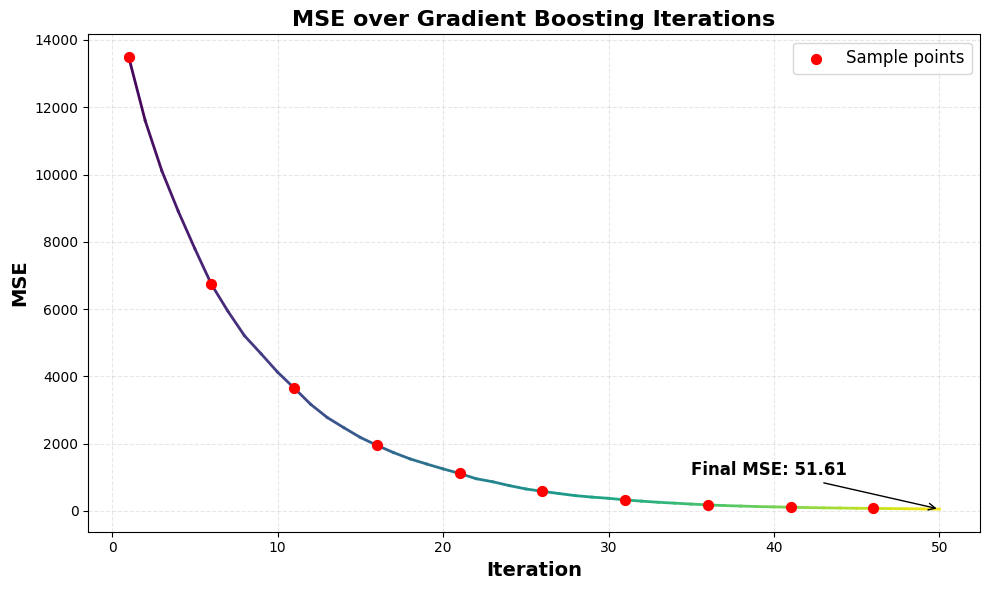

In [77]:
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt

X, y = make_regression(n_samples=50, n_features=5, noise=5, random_state=42)

model = TinyGBRegressor(n_estimators=50, learning_rate=0.1, max_depth=3, score_func='L2')
model.fit(X, y)
y_pred = model.predict(X)

mse = np.mean((y - y_pred) ** 2)
print(f"Final MSE:", mse)

import matplotlib.pyplot as plt
import numpy as np

mse_history = model.mse_history
iterations = np.arange(1, len(mse_history) + 1)

plt.figure(figsize=(10, 6))

for i in range(1, len(iterations)):
    plt.plot(iterations[i-1:i+1], mse_history[i-1:i+1],
             color=plt.cm.viridis(i / len(iterations)), linewidth=2)

plt.scatter(iterations[::5], np.array(mse_history)[::5],
            color='red', s=50, zorder=5, label='Sample points')

plt.xlabel("Iteration", fontsize=14, fontweight='bold')
plt.ylabel("MSE", fontsize=14, fontweight='bold')
plt.title("MSE over Gradient Boosting Iterations", fontsize=16, fontweight='bold')

plt.grid(alpha=0.3, linestyle='--')

plt.annotate(f'Final MSE: {mse_history[-1]:.2f}',
             xy=(iterations[-1], mse_history[-1]),
             xytext=(iterations[-1]-15, mse_history[-1]+1000),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=12, fontweight='bold')

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

In [58]:
from sklearn.ensemble import GradientBoostingRegressor
sk_model = GradientBoostingRegressor(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3
    )

sk_model.fit(X, y)
np.mean((y - sk_model.predict(X))**2)

np.float64(52.90327477146544)

In [70]:
from sklearn.tree import DecisionTreeRegressor

class LogLossGradientBoostingClassification:
  def __init__(self, n_estimators=10, learning_rate=0.1, max_depth=3):
    self.n_estimators = 10
    self.learning_rate = learning_rate
    self.max_depth = max_depth
    self.F0 = None

  @staticmethod
  def sigmoid(z):
    return 1 / (1 + np.exp(-z))

  def fit(self, X, y):
    self.F0 = np.log(np.mean(y))
    F = np.full_like(y, self.F0, dtype=float)
    self.trees = []

    for _ in range(self.n_estimators):
      p = self.sigmoid(F)
      residuals = y - p

      tree = DecisionTreeRegressor(max_depth=self.max_depth)
      tree.fit(X, residuals)

      update = tree.predict(X)
      F += self.learning_rate * update

      self.trees.append(tree)

  def predict_raw(self, X):
    F = np.full(X.shape[0], self.F0, dtype=float)
    for tree in self.trees:
      F += self.learning_rate * tree.predict(X)
    return F

  def predict_proba(self, X):
    F = self.predict_raw(X)
    return self.sigmoid(F)

  def predict(self, X, threshold=0.4):
    return (self.predict_proba(X) >= threshold).astype(int)




In [72]:
np.random.seed(42)
X_test = np.random.randn(20, 3)
y_test = (X_test[:, 0] + X_test[:, 1] * 0.5 > 0).astype(int)

model = LogLossGradientBoostingClassification(n_estimators=10000, learning_rate=0.2, max_depth=5)
model.fit(X_test, y_test)

probs = model.predict_proba(X_test)
preds = model.predict(X_test)

print("True labels:     ", y_test)
print("Predicted labels:", preds)
print("Predicted probs: ", np.round(probs, 2))

True labels:      [1 1 1 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0]
Predicted labels: [1 1 1 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0]
Predicted probs:  [0.56 0.56 0.56 0.56 0.2  0.2  0.2  0.2  0.2  0.56 0.56 0.2  0.2  0.56
 0.2  0.2  0.2  0.2  0.56 0.2 ]
